In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn import metrics


import copy
import warnings

warnings.filterwarnings("ignore")

np.random.seed(0)

pd.set_option("mode.copy_on_write", True)

In [119]:
# Reading the data (real world data)
training_data = pd.read_csv("../../01_Data/02_Processed/train.csv")
test_data = pd.read_csv("../../01_Data/02_Processed/test.csv")

In [120]:
training_data.sample(5)

,offensive,class,tokenized,clean_tweet
6277,No,2,"['winston', 'connect', 'green', 'slant', 'acro...",winston connects greene slant across middle s...
3013,No,2,"['yanke', 'birth', 'live', 'much', 'life', 'no...",yankee birth lived much life north see diff le...
5434,No,2,"['well', 'done', 'correctli', 'answer', 'almer...",well done correctly answered almeria yellow r...
4910,Yes,1,"['meek', 'nut', 'shit', 'one', 'time', 'bitch'...",meek nut shit one time bitch guess yall forgot...
2709,Yes,1,"['call', 'fireman', 'caus', 'turn', 'hoe']",call fireman cause turn hoes


In [121]:
# Extracting just the features (clean_tweet) and the labels (offensive yes/no)
x_train, y_train = training_data.iloc[:, -1], training_data.iloc[:, 0]
x_test, y_test = test_data.iloc[:, -1], test_data.iloc[:, 0]
y_train = y_train.map({"Yes": 1, "No": 0})
y_test = y_test.map({"Yes": 1, "No": 0})

In [122]:
x_train.sample(5)

3039     yankees didnt want russell martin signed pira...
4756                      mannnn tonight feels like trash
5875     rick scott refuses appear debate stage charli...
4041                                   bitch ass nigggaaa
4477                          denzy tryna hoe broski izzy
Name: clean_tweet, dtype: object

Encoding text using the most frequent terms in the corpus

In [123]:
x_train.shape

(6400,)

In [124]:
# padding with zeros - adding zeroes to the left of the sequence to make it of a fixed length for future analyses
def add_padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, tweet_numeric in enumerate(sentences):
        # print(i, tweet_numeric)
        if len(tweet_numeric) != 0:
            features[i, -len(tweet_numeric) :] = np.array(tweet_numeric)[:seq_len]
    return features


# Vectorize dataset - convert text to numbers
def tokenize_text(x_train, y_train, x_val, y_val):
    word_list = []

    for sentence in x_train:
        for word in sentence.split():
            if word != "":
                word_list.append(word)

    # make vocab dictionary
    corpus = Counter(word_list)  # count the number of each word occurs in the word list
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:5000]
    onehot_dictionary = {w: i + 1 for i, w in enumerate(corpus_)}
    # print("Corpus:", corpus)
    # print("Corpus_:", len(corpus_), corpus_)
    # print("onehot_dictionary:", len(onehot_dictionary), onehot_dictionary)
    # tokenize
    train_sent, test_sent = [], []
    for sent in x_train:
        train_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )
    for sent in x_val:
        test_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )

    # Pad sequences
    train_sent = add_padding(train_sent, 30)
    test_sent = add_padding(test_sent, 30)
    # print("train_sent: ", train_sent)
    # print("test_sent: ", test_sent)
    return (
        np.array(train_sent),
        np.array(y_train),
        np.array(test_sent),
        np.array(y_val),
        onehot_dictionary,
    )


print("x_train: ", x_train.shape)
print("Tokenizing text...")
x_train, y_train, x_test, y_test, vocab = tokenize_text(
    x_train, y_train, x_test, y_test
)
print("x_train: ", x_train.shape)

x_train:  (6400,)
Tokenizing text...
x_train:  (6400, 30)


In [125]:
np.sum(x_train, axis=0)

array([      0,       0,       0,       0,       0,       0,       0,
           241,     601,     724,    1326,    9606,   21165,   29631,
         44858,  108973,  230647,  369556,  529918,  834932, 1256724,
       1617299, 2047273, 2492894, 2935357, 3593373, 3963654, 4440278,
       4994746, 5338047])

In [127]:
print(f"Length of vocabulary is {len(vocab)}")

Length of vocabulary is 5000


Discriminative process for classification

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [12]:
# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(x_train), torch.from_numpy(y_train.astype("int"))
)
valid_data = TensorDataset(
    torch.from_numpy(x_test), torch.from_numpy(y_test.astype("int"))
)

# dataloaders
batch_size = 50

# Shuffling the data and creating batches of data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [13]:
# obtain one batch of training data
iterated_data = iter(train_loader)
sample_x, sample_y = next(iterated_data)

print("Sample input size:", sample_x.size())  # batch_size, seq_length
print("Sample input features:", sample_x)
print("Sample input labels:", sample_y)

Sample input size: torch.Size([50, 30])
Sample input features: tensor([[   0,    0,    0,  ...,  730,  957, 2980],
        [   0,    0,    0,  ...,   23,  173,   13],
        [   0,    0,    0,  ...,   11,  977,  370],
        ...,
        [   0,    0,    0,  ...,   96,   69,  193],
        [   0,    0,    0,  ...,  552,  931,  114],
        [   0,    0,    0,  ...,    1, 1271,  310]])
Sample input labels: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1])


# LSTM Classifier Architecture

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dim, embedding_dim):
        super(LSTMClassifier, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.n_layers = n_layers
        self.vocab_size = vocab_size

        # embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            batch_first=True,
            dropout=0.2,
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        # linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initializes hidden state"""
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [15]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [16]:
n_layers = 2
vocab_size = len(vocab) + 1  # extra 1 for padding
embedding_dim = 30
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers, vocab_size, hidden_dim, embedding_dim)

# moving to gpu
model.to(device)

print(model)

LSTMClassifier(
  (embedding): Embedding(5001, 30)
  (lstm): LSTM(30, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


LSTM Training

In [17]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [18]:
clip = 5
epochs = 5
best_loss = float("inf")
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(
        epoch + 1,
        epochs,
        epoch_train_loss,
        epoch_val_loss,
        epoch_train_acc * 100,
        epoch_val_acc * 100,
    )
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), "state_dict.pt")
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                best_loss, epoch_val_loss
            )
        )
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70 * "==")

Epoch[1/5], Train Loss: 0.5454 | Valid Loss: 0.3967 | Train Acc: 71.34 | Valid Acc: 82.88
Validation loss decreased (inf --> 0.396669).  Saving model ...
Epoch[2/5], Train Loss: 0.3075 | Valid Loss: 0.2772 | Train Acc: 87.95 | Valid Acc: 89.56
Validation loss decreased (0.396669 --> 0.277196).  Saving model ...
Epoch[3/5], Train Loss: 0.2236 | Valid Loss: 0.2427 | Train Acc: 91.83 | Valid Acc: 91.00
Validation loss decreased (0.277196 --> 0.242726).  Saving model ...
Epoch[4/5], Train Loss: 0.1868 | Valid Loss: 0.2384 | Train Acc: 93.36 | Valid Acc: 92.19
Validation loss decreased (0.242726 --> 0.238423).  Saving model ...
Epoch[5/5], Train Loss: 0.1510 | Valid Loss: 0.2287 | Train Acc: 94.77 | Valid Acc: 92.69
Validation loss decreased (0.238423 --> 0.228685).  Saving model ...


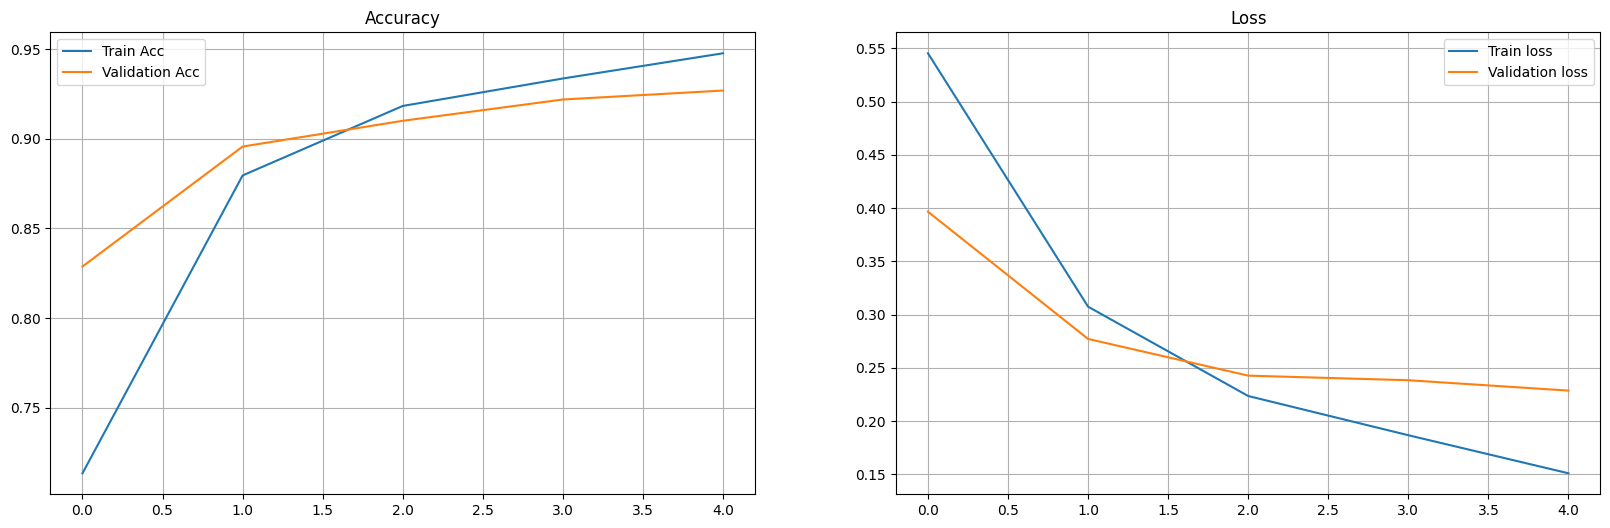

In [23]:
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train Acc")
plt.plot(epoch_vl_acc, label="Validation Acc")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Model Evaluation against validation set

In [24]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))

Test Accuracy: 92.69


Text(0.5, 1.0, 'class 0 (specificity): 0.959 | class 1 (sensitivity): 0.895')

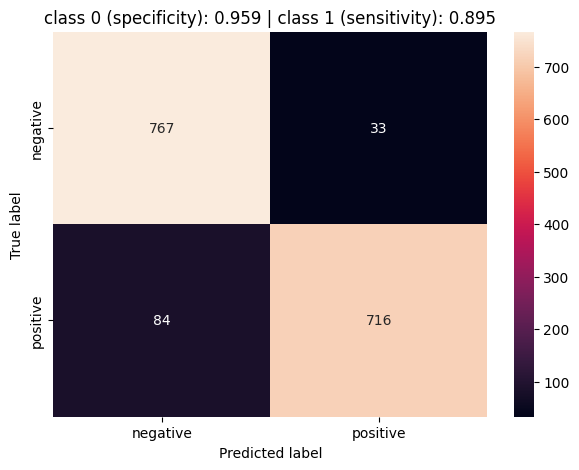

In [131]:
# sns.heatmap(df_cm, annot=True, fmt="g", cmap="YlGnBu")
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)

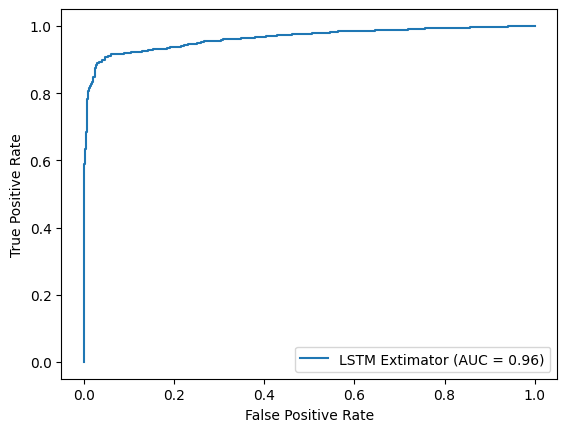

In [26]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Extimator"
)
display1.plot()
plt.show()

>Potentially add some example model results here - true positives and true negatives